<a href="https://colab.research.google.com/github/pkolachi/geodist2typfeat/blob/master/exptnbs/sigtyp-st2020-part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 60
%matplotlib inline
fpurl   = 'https://raw.githubusercontent.com/sigtyp/ST2020/master/data/train.csv'
# the header from the csv is not properly tab-seperated. hence hard-coding
header  = ['wals_code', 'name', 
           'latitude', 'longitude', 
           'genus', 'family', 'countrycodes', 
           'features'
          ]

REPEAT  = 1
CVFOLDS = 2   # default: 2 folds
N = -1        # default: use all samples 
K = 5         # default: use only 5 feature classes
# turn this on iff running from command-line to test performance across 
# different values for (CVFOLDS, K, REPEAT) 
BATCH = False  

from IPython.display import display as pd_displayHTML

Autosaving every 60 seconds


I hoped the provided train/test dataset is CSV compliant so that loading the dataset is as simple as using *pandas.read_csv*. It turned out not to be the case. The problem is with the header in the provided csv file, which makes inferring the columns using *header=auto* impossible. This is easily handled by hard-coding the column names in the header and skipping the first row when using *pandas.read_csv*.

In [2]:
import sys
!{sys.executable} -m pip install -q --user pandas
import pandas as pd
df = pd.read_csv(fpurl, sep='\t', header=None, names=header, 
                 error_bad_lines=True, skiprows=[0])
"""
# since this pynb will never be run on the held-out test set
if CVFOLDS <= 1:
  trnS, tstS = 0, 0   # dummy values for sizes of train and test partitions
else:
  tstdf = pd.read_csv(tstfpurl, sep='\t', header=None, names=header, 
                      error_bad_lines=True, skiprows=[0])
  trnS, tstS = df.shape[0], tstdf.shape[0]
  df.append(tstdf) 
"""
featsFull = df.iloc[:,0:-1]
clablFull = df.iloc[:,-1]
alablFull = pd.DataFrame([dict(f.split('=', 1) for f in inst.split('|'))
                          for inst in clablFull
                         ])
print(featsFull.shape, clablFull.shape, alablFull.shape)

(1125, 7) (1125,) (1125, 185)


Let's plot a few simple statistics about the dataset. 
1.   Histogram of the complex labels in the dataset
2.   Scatterplots of genus vs labels, family vs labels and countrycodes vs labels

In [3]:
!{sys.executable} -m pip install -q --user seaborn 
import seaborn as sns
def plot_datastats(features, clabels, alabels):
  return

if not BATCH:
  plot_datastats(featsFull, clablFull, alablFull)

The dataset is loaded into a DataFrame and seperated into two parts: input features and output labels. 

We know a few things about the input features like what are categorical features and what are numerical features. So, we encode the different columns in the feats DataFrame accordingly. *Hopefully this matters* when training different classifiers (especially thinking of decision trees). 

At this point, I'm not looking at best encoding scheme for the labels which are composite labels themselves (more on this later). The training dataset provided has 1109 unique labels for the dataset of 1125 languages. This indicates that there is *an optimal representation* for the label set.

In [4]:
from collections import defaultdict
for incol in ['wals_code', 'name', 'genus', 'family', 'countrycodes']:
  featsFull[incol] = featsFull[incol].astype('category')
clablFull = clablFull.astype('category')
alablFull = alablFull.astype('category')
alablTabl = ['{0}={1}'.format(fcn, lbl) for fcn in alablFull.columns
             for lbl in alablFull.loc[:,fcn].unique() if not pd.isna(lbl)
            ]
alablTabl = defaultdict(lambda: -1, ((v,i) for i,v in enumerate(alablTabl)))

X   = featsFull
ccs = featsFull.select_dtypes(['category']).columns 
X[ccs] = X[ccs].apply(lambda x: x.cat.codes)

Y = clablFull.cat.codes

Y_  = alablFull
ccs = Y_.select_dtypes(['category']).columns
Y_[ccs] = Y_[ccs].apply(lambda x: x.cat.codes)

X  = X.to_numpy()
Y  = Y.to_numpy()
Y_ = Y_.to_numpy()
print(X.shape, Y.shape, Y_.shape)

(1125, 7) (1125,) (1125, 185)


In [5]:
# sub-select data frame/matrix to speed-up experiments while debugging
import random
import numpy as np
# because we want sampling without replacement when we work with selected 
# features classes to test, using random makes statistics across runs 
# incomparable -- so use a uniform distribution to select feature classes for 
# comparison across different experiments. 
# to get robust estimates while testing, use random selection
if N < 0 or N > X.shape[0]:
  subsid = list(range(X.shape[0]))
else:
  #subsid = list(sorted(random.sample(range(X.shape[0]), N)))
  subsid = list(range(0, X.shape[0], X.shape[0]//N))[:N]
if K < 0 or K > Y_.shape[1]:
  subfci = list(range(Y_.shape[1]))
else:
  subfci = list(sorted(random.sample(range(Y_.shape[1]), K)))
  #subfci = list(range(0, Y_.shape[1], Y_.shape[1]//K))[:K])
subfcs = list(alablFull.columns[i] for i in subfci)

featsFull = featsFull.iloc[subsid,:]
clablFull = clablFull.iloc[subsid]
alablSub  = alablFull.iloc[subsid,subfci]
alablFull = alablFull.iloc[subsid,:]

X, Y, Y_ = X[subsid,:], Y[subsid], Y_[subsid,:]
subY_    = Y_[:,subfci]
print(featsFull.shape, clablFull.shape, alablFull.shape, alablSub.shape)
print(X.shape, Y.shape, Y_.shape, subY_.shape)

(1125, 7) (1125,) (1125, 185) (1125, 5)
(1125, 7) (1125,) (1125, 185) (1125, 5)


Let us try a few classifiers using *scikit-learn* at this point. 

For what it is worth, the accuracies can be worse than a coin flip, considering the sparse label set.


 features of languages spoken in close proximity and belonging to the same family should be highly informative in predicting the typographical features for a new language. 

In [6]:
%%time
!{sys.executable} -m pip install -q --user sklearn 
from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier

classifiers = {'knn':    KNeighborsClassifier(),
              #'lsvm':   SVC(kernel="linear"),
              #'rbfsvm': SVC(gamma=2),
              #'gp':     GaussianProcessClassifier(),
               'dt':     DecisionTreeClassifier(),
               'rf':     RandomForestClassifier(), #default worse than suggested values
               'mlp':    MLPClassifier(), #default worse than suggested values
               'adb':    AdaBoostClassifier(),
               'nb':     GaussianNB(),
              #'qda':    QuadraticDiscriminantAnalysis(),
               'ridge':  RidgeClassifier() 
              }
statnames = ['Classifiers', 'Avg. Test-acc', 'Avg. Train-acc', 
             'Std. Test-acc',  'Std. Train-acc',
             'Avg. Test-time', 'Avg. Train-time'
            ]
statcodes = ['clfn', 'mtsts', 'mtrns', 'vtsts', 'vtrns', 'predt', 'trint']

REPEAT  = REPEAT  if REPEAT  >  1 else 1  # sanity-check
CVFOLDS = CVFOLDS if CVFOLDS >= 2 else 2  # sanity-check
# scikit-learn documentation recommends using StratifiedKFold for classification
# problems to preserve class balance across folds. however, in this case, 
# we use KFold and RepeatedKFold because 
#  number of items in a class <= CVFOLDS (works only with 2 folds for entire dataset)
#  there is not much balance to preserve w.r.t. complex labels
cvsplits = list(RepeatedKFold(n_splits=CVFOLDS, 
                              n_repeats=REPEAT, random_state=20200408
                             ).split(X, Y)
               )
print(len(cvsplits))

2
CPU times: user 293 ms, sys: 94.4 ms, total: 387 ms
Wall time: 1.87 s


In [7]:
def plot_accuracies(accdf):
  sns.barplot(x="Classifiers", y="Avg. Test-acc", data=accdf)
  #ax2 = sns.barplot(x="Classifiers", y="Avg. Train accuracy", data=accdf)
  #ax2.set(ylim=(0, 100))
  return

/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


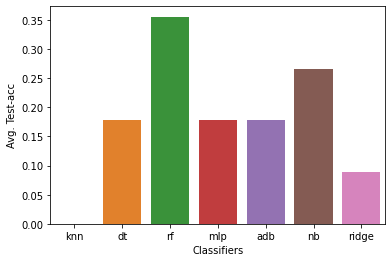

In [8]:
#%%time
from sklearn import model_selection as skms

def trainFullClassifiersCV(X, Y):
  clfaccs = []
  for iclf, nclf in enumerate(classifiers):
    clfsce = skms.cross_validate(classifiers[nclf], X, Y, cv=cvsplits, 
                                 return_train_score=True
                                )
    clfnfo = [nclf, 
              100*clfsce['test_score'].mean(), 100*clfsce['train_score'].mean(),
              100*clfsce['test_score'].std(),  100*clfsce['train_score'].std(),
              clfsce['score_time'].mean(), clfsce['fit_time'].mean()
             ]
    clfaccs.append(dict(zip(statnames, clfnfo)))
  return pd.DataFrame(clfaccs)

clfaccs = trainFullClassifiersCV(X, Y)
if not BATCH:
  plot_accuracies(clfaccs)

/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library

Classifiers,Avg. Test-acc,Avg. Train-acc,Std. Test-acc,Std. Train-acc,Avg. Test-time,Avg. Train-time
knn,67.626000,75.093000,0.844000,0.630000,0.120000,0.004000
dt,62.435000,100.000000,0.634000,0.000000,0.002000,0.015000
rf,69.920000,97.351000,0.916000,0.338000,0.010000,0.095000
mlp,63.270000,70.986000,1.705000,2.633000,0.006000,1.389000
adb,64.336000,66.099000,3.737000,3.482000,0.069000,0.460000
nb,70.968000,71.021000,0.603000,0.986000,0.006000,0.007000
ridge,71.057000,71.270000,1.128000,0.950000,0.003000,0.010000
-dumbase-,63.911000,63.911000,0.554000,0.554000,0.000000,0.000000


CPU times: user 5.42 s, sys: 206 ms, total: 5.63 s
Wall time: 5.01 s


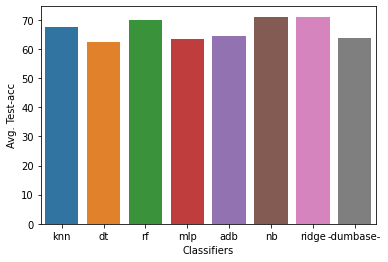

In [9]:
%%time
from sklearn import metrics as skmt

def trainIndClassifiersCV(X, matY, return_clfinsts=False):
  lclfinst  = {}  # table to store classifiers for later use
  lclfaccs = np.zeros((matY.shape[1], len(classifiers), 6))
  avgcaccs = []
  for iclf, nclf in enumerate(classifiers):
    for indY in range(matY.shape[1]):
      clfsce = skms.cross_validate(classifiers[nclf], X, matY[:,indY], cv=cvsplits,
                                   return_train_score=True, 
                                   return_estimator=return_clfinsts
                                  )
      lclfaccs[indY][iclf] = [100*clfsce['test_score'].mean(), 
                              100*clfsce['train_score'].mean(), 
                              100*clfsce['test_score'].std(),  
                              100*clfsce['train_score'].std(), 
                              clfsce['score_time'].mean(), 
                              clfsce['fit_time'].mean()
                             ]
      if return_clfinsts:
        lclfinst[(iclf, indY)] = clfsce['estimator']
    clfnfo = [nclf, 
              lclfaccs[:,iclf,0].mean(), lclfaccs[:,iclf,1].mean(),
              lclfaccs[:,iclf,2].mean(), lclfaccs[:,iclf,3].mean(),
              lclfaccs[:,iclf,4].sum(),  lclfaccs[:,iclf,5].sum()
             ]
    avgcaccs.append(dict(zip(statnames, clfnfo)))
  # use a constant estimator that always says the labelvalue for any featureclass is n/a
  # don't store instances of this dumbase classifier
  lclfaccs = np.zeros((matY.shape[1], 6))
  for indY in range(matY.shape[1]):
    dumbTstAccs = np.array([skmt.accuracy_score(matY[tstids,indY], 
                                                np.full((tstids.shape[0], 1), -1)
                                               )
                            for _,tstids in cvsplits
                           ])
    dumbTrnAccs = np.array([skmt.accuracy_score(matY[trnids,indY],
                                                np.full((trnids.shape[0], 1), -1)
                                               )
                            for trnids,_ in cvsplits
                           ])
    lclfaccs[indY] = [100*dumbTstAccs.mean(), 100*dumbTrnAccs.mean(), 
                      100*dumbTstAccs.std(),  100*dumbTrnAccs.std(), 
                      0, 0
                     ]
  bclfnfo = ['-dumbase-',  
             lclfaccs[:,0].mean(), lclfaccs[:,1].mean(), 
             lclfaccs[:,2].mean(), lclfaccs[:,3].mean(), 
             lclfaccs[:,4].sum(),  lclfaccs[:,5].sum()
            ]
  avgcaccs.append(dict(zip(statnames, bclfnfo)))
  if return_clfinsts:
    return (pd.DataFrame(avgcaccs), lclfinst)
  else:
    return pd.DataFrame(avgcaccs)

avgcaccs, lclclfs = trainIndClassifiersCV(X, subY_, return_clfinsts=True)
if not BATCH:
  #print(avgcaccs.round(3).to_markdown(showindex=False))
  pd_displayHTML(avgcaccs.round(3).style.hide_index())
  plot_accuracies(avgcaccs)  

Sanity check failed


/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifiers,Avg. Test-acc,Avg. Train-acc,Std. Test-acc,Std. Train-acc,Avg. Test-time,Avg. Train-time
knn,17.868000,38.667000,0.994000,0.834000,0.032000,0.001000
dt,16.267000,100.000000,0.074000,0.000000,0.001000,0.008000
rf,21.689000,98.045000,0.019000,0.354000,0.010000,0.045000
mlp,14.223000,45.416000,0.368000,7.160000,0.003000,1.179000
adb,23.910000,25.510000,0.779000,0.955000,0.050000,0.144000
nb,14.042000,32.626000,2.654000,4.029000,0.008000,0.008000
ridge,22.311000,24.177000,0.425000,0.334000,0.001000,0.002000


CPU times: user 4.67 s, sys: 368 ms, total: 5.04 s
Wall time: 3.3 s


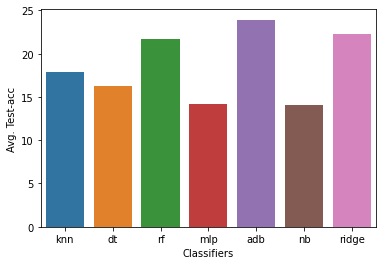

In [10]:
%%time 
clablSub = ['|'.join('{0}={1}'.format(k,v) for k,v in row.items() if not pd.isna(v))
            for row in alablSub.to_dict(orient='records')
           ]
# sanity check to make sure subset of labels have been properly extracted
if all(True if nl=='' or l.find(sf)!=-1 else False
       for l,nl in zip(clablFull.values, clablSub) for sf in nl.split('|')):
  print('Sanity check passed')
else:
  print('Sanity check failed')
clablSub = pd.Series(clablSub, name=header[-1])
subY = clablSub.astype('category').cat.codes
subY = subY.to_numpy()
sclfaccs = trainFullClassifiersCV(X, subY)
if not BATCH:
  pd_displayHTML(sclfaccs.round(3).style.hide_index())
  plot_accuracies(sclfaccs)

Classifiers,Avg. Test-acc,Avg. Train-acc,Std. Test-acc,Std. Train-acc
knn,15.734000,30.667000,0.636000,0.116000
dt,12.001000,100.000000,0.988000,0.000000
rf,19.556000,87.911000,0.195000,0.366000
mlp,10.222000,22.400000,0.098000,0.553000
adb,13.421000,15.203000,1.499000,3.480000
nb,21.511000,22.044000,0.197000,1.047000
ridge,20.799000,22.132000,1.226000,1.314000


CPU times: user 1.02 s, sys: 25.5 ms, total: 1.04 s
Wall time: 944 ms


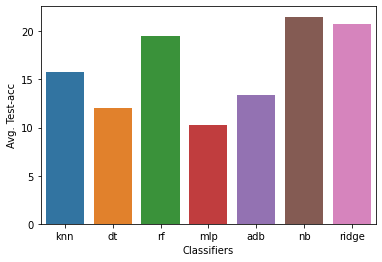

In [11]:
%%time
def skmt_mlmc_accuracy_score(y_true, y_pred):
  "Classification accuracy for multi-label multi-class problems"
  n_samples = y_true.shape[0]
  return sum(1.0 if np.array_equal(y_true[i], y_pred[i]) else 0
             for i in range(n_samples)
            ) / n_samples

def jntTestIndClassifiersCV(X, matY, clfinstances=None):
  if not clfinstances:
    _, clfinstances = trainIndClassifiersCV(X, matY, return_clfinsts=True)
  trncvsplits = [(trnids, trnids) for trnids, tstids in cvsplits] 
  trnpartsids = [trnids for trnids, tstids in cvsplits]
  tstpartsids = [tstids for trnids, tstids in cvsplits]
  predOnSubst = lambda clf,sid: clf.predict(X[sid]).reshape(-1, 1)
  jclfaccs = []
  for iclf, nclf in enumerate(classifiers):
    tstpreds = []
    for tstpid, tstids in enumerate(tstpartsids):
      tstpreds.append(np.hstack([clfinstances[(iclf, indY)][tstpid].predict(X[tstids]).reshape((-1,1)) for indY in range(matY.shape[1])]))  
    trnpreds = []
    for trnpid, trnids in enumerate(trnpartsids):
      trnpreds.append(np.hstack([clfinstances[(iclf, indY)][trnpid].predict(X[trnids]).reshape((-1,1)) for indY in range(matY.shape[1])]))
    tstaccs = 100*np.array([skmt_mlmc_accuracy_score(matY[instids], pred) for instids, pred in zip(tstpartsids, tstpreds)])
    trnaccs = 100*np.array([skmt_mlmc_accuracy_score(matY[instids], pred) for instids, pred in zip(trnpartsids, trnpreds)])
    clfnfo = [nclf, tstaccs.mean(), trnaccs.mean(), tstaccs.std(), trnaccs.std()]
    jclfaccs.append(dict(zip(statnames, clfnfo)))
  return pd.DataFrame(jclfaccs)

jclfaccs = jntTestIndClassifiersCV(X, subY_, clfinstances=lclclfs)
if not BATCH:
  pd_displayHTML(jclfaccs.round(3).style.hide_index())
  plot_accuracies(jclfaccs)

TODO: 

*   test other encoding schemes (one-hot encoding and rest in scikit-learn) 
*   hyper-parameter search and pick 3 classifiers
*   also pick an optimal encoding scheme
*   test some manual feature additions like geographic distances
*   also check l1 regularization and see which features matter the most
*   DT/RF & MLP seem to have non-convex optimizations or some other random seed initialization. can't replicate results when run multiple times.

In [14]:
Ymlbl  = np.zeros((Y.shape[0], len(alablTabl)))
print(len(alablTabl))
filidx = np.array([ (irow, alablTabl['{0}={1}'.format(fcn, lbl)])
                    for irow, row in enumerate(alablFull.to_dict(orient='records'))
                    for fcn, lbl in row.items() if not pd.isna(lbl)
                  ])
Ymlbl[[filidx[:,0], filidx[:,1]]] = 1

subYmlbl = np.zeros((Y.shape[0], len(alablTabl)))
filidx = np.array([ (irow, alablTabl['{0}={1}'.format(fcn, lbl)])
                    for irow, row in enumerate(alablSub.to_dict(orient='records'))
                    for fcn, lbl in row.items() if not pd.isna(lbl)
                  ])
subYmlbl[[filidx[:,0], filidx[:,1]]] = 1
print(Ymlbl.shape, subYmlbl.shape)

2131
(1125, 2131) (1125, 2131)


/Users/admin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
/Users/admin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifiers,Avg. Test-acc,Avg. Train-acc,Std. Test-acc,Std. Train-acc,Avg. Test-time,Avg. Train-time
knn,100.000000,100.000000,0.000000,0.000000,42.957000,0.132000
dt,100.000000,100.000000,0.000000,0.000000,0.097000,0.124000
rf,100.000000,100.000000,0.000000,0.000000,0.563000,1.307000
mlp,100.000000,100.000000,0.000000,0.000000,0.085000,13.063000


CPU times: user 3min 43s, sys: 5.6 s, total: 3min 49s
Wall time: 3min 27s


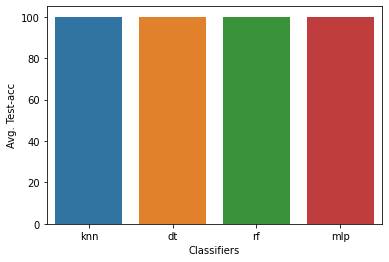

In [15]:
%%time
mlblclasfrs = {'knn': KNeighborsClassifier(),
               'dt':  DecisionTreeClassifier(),
               'rf':  RandomForestClassifier(), #default worse than suggested values
               'mlp': MLPClassifier(), #default worse than suggested values
              }
global classifiers
classifiers = mlblclasfrs
mlbclfaccs  = trainFullClassifiersCV(X, Ymlbl)
if not BATCH:
  pd_displayHTML(mlbclfaccs.round(3).style.hide_index())
  plot_accuracies(mlbclfaccs)

/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/admin/Library/Python/3.7/lib/python/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Classifiers,Avg. Test-acc,Avg. Train-acc,Std. Test-acc,Std. Train-acc,Avg. Test-time,Avg. Train-time
knn,100.000000,100.000000,0.000000,0.000000,50.776000,0.162000
dt,100.000000,100.000000,0.000000,0.000000,0.113000,0.146000
rf,100.000000,100.000000,0.000000,0.000000,0.681000,1.585000
mlp,100.000000,100.000000,0.000000,0.000000,0.091000,14.182000


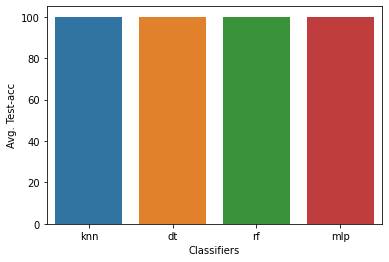

In [16]:
global classifiers
classifiers = mlblclasfrs
smlbclaccs  = trainFullClassifiersCV(X, subYmlbl)
if not BATCH:
  pd_displayHTML(smlbclaccs.round(3).style.hide_index())
  plot_accuracies(smlbclaccs)

In [ ]:
if BATCH:
  global CVFOLDS, K, REPEAT
  global X, Y, Y_, subys
  for cvf in range(2, 6):
    CVFOLDS = cvf
    for reptr in range(1, 3):
      REPEAT = reptr
      for k in range(5, 100, 10):
        K = k